<a href="https://colab.research.google.com/github/sulaimanbehzad/Clustering_according_to_item_popularity/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Clustering of Digikala dataset based on items popularity  


In [5]:
# ! pip install scikit-learn-extra 

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, normalize
# from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

### Cloning the github repository in colab

In [7]:
% cd /content/drive/MyDrive/Clustering_according_to_item_popularity/


/content/drive/MyDrive/Clustering_according_to_item_popularity


In [8]:
# ! ls

In [9]:
# ! git clone https://github.com/sulaimanbehzad/Clustering_according_to_item_popularity.git

In [10]:
! git status

On branch main
Your branch and 'origin/main' have diverged,
and have 2 and 7 different commits each, respectively.
  (use "git pull" to merge the remote branch into yours)

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Clustering_according_to_item_popularity/
	preprocessed_item_recomm.csv

nothing added to commit but untracked files present (use "git add" to track)


In [82]:
! git config --global user.email "sulaimanbehzad@example.com"
! git config --global user.name "sulaimanbehzad"
! git pull

error: The following untracked working tree files would be overwritten by merge:
	preprocessed_item_recomm.csv
Please move or remove them before you merge.
Aborting


In [12]:
# ! git push -u origin main

In [13]:
# ! git commit -m 'redundant files removed'

### Reading and preprocessing the dataset

In [14]:
df = pd.read_excel('/content/drive/MyDrive/Clustering_according_to_item_popularity/keifiat.xlsx')

In [15]:
df.head()

,product_id,product_title,title_en,user_id,likes,dislikes,verification_status,recommend,title,comment,advantages,disadvantages
0,3692,ماوس بی‌سیم لاجیتک مدل M325,IT,989472,0,0,verified,\N,NaN,واقعا عالیه. من که ازش خیلی راضیم,NaN,NaN
1,90213,شارژر همراه شیاومی مدل NDY-02-AN با ظرفیت 1000...,AC,3862150,4,1,verified,recommended,واقعاً عالیه,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...,"[""عمر طولانی\r"",""افت بسیار کم میزان شارژ\r"",""ا...","[""ندارد""]"
2,59473,یدک پولیشر میکروفایبر مهسان مدل 20119,HW,626843,1,0,verified,not_recommended,خیلی سخت حوله اش در میاد,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...,NaN,NaN
3,120499,گوشی موبایل هوآوی آنر مدل 5X KIW-L21 دو سیم‌کارت,MO,786887,6,11,verified,no_idea,گوشی مقرون به صرفه,همه چیز در رابطه با ظاهر این گوشی بسیار خوب اس...,"[""صفحه نمایش پرنور و با کیفیت\r"",""کیفیت بالای ...","[""کیفیت پایین اسپیکر\r"",""حاشیه خالی زیر صفحه ن..."
4,67200,شارژر همراه شیائومی مدل Mi ظرفیت 5000 میلی آمپ...,AC,854531,19,4,verified,no_idea,ابعاد، استحکام و نگهداری شارژ مناسب,اگر ظرفیتش براتون کافیه حتما بخرید.\r\nیه شارژ...,"[""ظریف و زیبا و باریک\r"",""بدنه محکم و با دوام""]","[""ظرفیت متوسط""]"


In [16]:
df.describe()

,product_id,user_id,likes,dislikes
count,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,426482.510140,4.642959e+06,3.114790,1.649460
std,232470.511159,2.619034e+06,8.050031,8.912705
min,300.000000,4.661320e+05,0.000000,0.000000
25%,220871.250000,2.613059e+06,0.000000,0.000000
50%,427858.000000,4.710290e+06,1.000000,0.000000
75%,619397.250000,7.094806e+06,4.000000,1.000000
max,909423.000000,8.623288e+06,854.000000,1344.000000


Select the attributes that will give information about the popularity of the item

In [17]:
df1 = df[['product_id', 'product_title','likes', 'dislikes','comment', 'recommend']]

Check the dataframe for null values and handle them

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_id     100000 non-null  int64 
 1   product_title  100000 non-null  object
 2   likes          100000 non-null  int64 
 3   dislikes       100000 non-null  int64 
 4   comment        99883 non-null   object
 5   recommend      100000 non-null  object
dtypes: int64(3), object(3)
memory usage: 4.6+ MB


In [19]:
df1.isnull().sum()

product_id         0
product_title      0
likes              0
dislikes           0
comment          117
recommend          0
dtype: int64

looking at the database 'recommend' we can see that \N values also represent null values which wouldn't be considered in the above

In [20]:
df1['recommend'].value_counts()

recommended        36972
\N                 36382
not_recommended    16110
no_idea            10536
Name: recommend, dtype: int64

we can see that beside the 117 missing values we have 36382 records with \N values  
now we understand tha \N too should be considered as missing value


In [21]:
missing_values = ["\\N", "na", "--", "NA", "n/a"]
df = pd.read_excel('/content/drive/MyDrive/Clustering_according_to_item_popularity/keifiat.xlsx', na_values = missing_values)
df1 = df[['product_id', 'product_title', 'likes', 'dislikes','comment', 'recommend']]


after importing database with newly found aspects on NA we are going to handle null values

In [22]:
df1.isnull().sum()

product_id           0
product_title        0
likes                0
dislikes             0
comment            118
recommend        36382
dtype: int64

In [23]:
df1['recommend'].value_counts()

recommended        36972
not_recommended    16110
no_idea            10536
Name: recommend, dtype: int64

In [24]:
most_common = df1["recommend"].value_counts().idxmax
# df1['recommend'].fillna(median, inplace=True)
most_common

<bound method Series.idxmax of recommended        36972
not_recommended    16110
no_idea            10536
Name: recommend, dtype: int64>

replacing the null values with one of the above would falsely impact the clustering so let's take another approach:  
1. use interpolation to find values
2. fill with mean/median

in order to use interpolation let us first use label encoder to obtain numerical values

In [25]:
df1['recommend'].fillna(value='null_values', inplace=True)
df1.isnull().sum()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


product_id         0
product_title      0
likes              0
dislikes           0
comment          118
recommend          0
dtype: int64

In [26]:
le = LabelEncoder()
le.fit(df1['recommend'])
le.classes_

array(['no_idea', 'not_recommended', 'null_values', 'recommended'],
      dtype=object)

In [27]:
recomm_trans = le.transform(df1['recommend'])
recomm_trans

array([2, 3, 1, ..., 3, 0, 0])

In [28]:
df1['recommend'] = recomm_trans

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
df1[['recommend']]

,recommend
0,2
1,3
2,1
3,0
4,0
...,...
99995,3
99996,2
99997,3
99998,0


In [30]:
df1['recommend'] = df1['recommend'].replace(2,np.nan)
df1['recommend']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        NaN
1        3.0
2        1.0
3        0.0
4        0.0
        ... 
99995    3.0
99996    NaN
99997    3.0
99998    0.0
99999    0.0
Name: recommend, Length: 100000, dtype: float64

In [31]:
recomm_filled = df1['recommend'].interpolate(method='linear')
recomm_filled.isnull().sum()

1

In [32]:
df1['recommend'] = recomm_filled
df1.head(50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,product_id,product_title,likes,dislikes,comment,recommend
0,3692,ماوس بی‌سیم لاجیتک مدل M325,0,0,واقعا عالیه. من که ازش خیلی راضیم,NaN
1,90213,شارژر همراه شیاومی مدل NDY-02-AN با ظرفیت 1000...,4,1,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...,3.000000
2,59473,یدک پولیشر میکروفایبر مهسان مدل 20119,1,0,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...,1.000000
3,120499,گوشی موبایل هوآوی آنر مدل 5X KIW-L21 دو سیم‌کارت,6,11,همه چیز در رابطه با ظاهر این گوشی بسیار خوب اس...,0.000000
4,67200,شارژر همراه شیائومی مدل Mi ظرفیت 5000 میلی آمپ...,19,4,اگر ظرفیتش براتون کافیه حتما بخرید.\r\nیه شارژ...,0.000000
5,133722,لپ تاپ 15 اینچی ایسوس مدل N501VW - A,6,1,سلام دوستان،،\r\nمنم مثه بعضی از دوستان قبل از...,3.000000
6,148509,اسپیکر بلوتوثی دیووم مدل Bluetune bean,3,0,من چند سالی هست که این اسپیکرو خریدم و واقعا ح...,3.000000
7,56871,ادو پرفیوم زنانه امپر مدل Chifon حجم 100 میلی ...,2,2,بوی تند ولی خوشبو داره.ماندگاریش خوبه و هر چقد...,2.000000
8,49738,ماشین اصلاح صورت رمینگتون مدل MB4555,2,1,متاسفانه عمر مفید این ماشین کم هست و بعد از دو...,1.000000
9,161548,فلاسک هنری مدل Virginia Special ظرفیت 1.9 لیتر,1,0,خوب بودممنون,0.000000


In [33]:
df1.isnull().sum()

product_id         0
product_title      0
likes              0
dislikes           0
comment          118
recommend          1
dtype: int64

In [34]:
df1.dropna(inplace=True)
df1.isnull().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


product_id       0
product_title    0
likes            0
dislikes         0
comment          0
recommend        0
dtype: int64

## handling NULL values is DONE!!! 

In [35]:
# df1.to_csv('preprocessed_item_recomm.csv',index=False, encoding='utf-8-sig')

In [36]:
prep_df = pd.read_csv('/content/drive/MyDrive/Clustering_according_to_item_popularity/preprocessed_item_recomm.csv')
prep_df['recommend']=prep_df['recommend'].round()
prep_df['recommend'] = pd.to_numeric(prep_df['recommend'], downcast='integer')
inv_tr=le.inverse_transform(prep_df['recommend'])
inv_tr

array(['recommended', 'not_recommended', 'no_idea', ..., 'recommended',
       'no_idea', 'no_idea'], dtype=object)

In [37]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99881 entries, 0 to 99880
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     99881 non-null  int64 
 1   product_title  99881 non-null  object
 2   likes          99881 non-null  int64 
 3   dislikes       99881 non-null  int64 
 4   comment        99881 non-null  object
 5   recommend      99881 non-null  int8  
dtypes: int64(3), int8(1), object(2)
memory usage: 3.9+ MB


In [38]:
dummies = pd.get_dummies(prep_df['recommend'])
dummies.head()

,0,1,2,3
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,0,0,0,1


recommended: 3  
not_recommended: 1  
no_idea: 0 

In [39]:
prep_df['recommended'] = dummies.iloc[:, 3]
prep_df['not_recommended'] = dummies.iloc[:, 1]
prep_df['no_idea'] = dummies.iloc[:, 0]
prep_df.drop(columns=['recommend'], inplace=True)
prep_df.head(10)

,product_id,product_title,likes,dislikes,comment,recommended,not_recommended,no_idea
0,90213,شارژر همراه شیاومی مدل NDY-02-AN با ظرفیت 1000...,4,1,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...,1,0,0
1,59473,یدک پولیشر میکروفایبر مهسان مدل 20119,1,0,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...,0,1,0
2,120499,گوشی موبایل هوآوی آنر مدل 5X KIW-L21 دو سیم‌کارت,6,11,همه چیز در رابطه با ظاهر این گوشی بسیار خوب اس...,0,0,1
3,67200,شارژر همراه شیائومی مدل Mi ظرفیت 5000 میلی آمپ...,19,4,اگر ظرفیتش براتون کافیه حتما بخرید.\r\nیه شارژ...,0,0,1
4,133722,لپ تاپ 15 اینچی ایسوس مدل N501VW - A,6,1,سلام دوستان،،\r\nمنم مثه بعضی از دوستان قبل از...,1,0,0
5,148509,اسپیکر بلوتوثی دیووم مدل Bluetune bean,3,0,من چند سالی هست که این اسپیکرو خریدم و واقعا ح...,1,0,0
6,56871,ادو پرفیوم زنانه امپر مدل Chifon حجم 100 میلی ...,2,2,بوی تند ولی خوشبو داره.ماندگاریش خوبه و هر چقد...,0,0,0
7,49738,ماشین اصلاح صورت رمینگتون مدل MB4555,2,1,متاسفانه عمر مفید این ماشین کم هست و بعد از دو...,0,1,0
8,161548,فلاسک هنری مدل Virginia Special ظرفیت 1.9 لیتر,1,0,خوب بودممنون,0,0,1
9,5107,هارددیسک اکسترنال سیگیت مدل Backup Plus Deskto...,1,0,نزدیک به دو ساله که این هارد رو خریدم. استفاده...,1,0,0


Here we aim to obtain sum of number times an item has been recommended 

In [40]:
sum_of_recomm = prep_df.groupby(by=['product_id'], as_index=False).sum()
sum_of_recomm.head(10)


,product_id,likes,dislikes,recommended,not_recommended,no_idea
0,300,5,1,2,1,0
1,310,2,0,1,0,0
2,352,0,0,0,0,1
3,363,0,0,1,0,0
4,423,0,0,1,0,0
5,481,1,0,0,0,0
6,482,1,1,1,0,0
7,485,0,0,0,0,0
8,496,0,0,0,0,1
9,515,9,0,1,0,0


Drop duplicates here



In [41]:
unique_products = prep_df.filter(['product_id', 'product_title'])
unique_products.drop_duplicates(subset='product_id', inplace=True, keep='first')
unique_products.head()

,product_id,product_title
0,90213,شارژر همراه شیاومی مدل NDY-02-AN با ظرفیت 1000...
1,59473,یدک پولیشر میکروفایبر مهسان مدل 20119
2,120499,گوشی موبایل هوآوی آنر مدل 5X KIW-L21 دو سیم‌کارت
3,67200,شارژر همراه شیائومی مدل Mi ظرفیت 5000 میلی آمپ...
4,133722,لپ تاپ 15 اینچی ایسوس مدل N501VW - A


In [42]:
unique_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50189 entries, 0 to 99879
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     50189 non-null  int64 
 1   product_title  50189 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


More than 49000 products with duplicate records were deleted as a result
let's save the preproccessed dataframe upto now

In [43]:
final_df = pd.merge(sum_of_recomm,unique_products,on="product_id")
final_df.head()

,product_id,likes,dislikes,recommended,not_recommended,no_idea,product_title
0,300,5,1,2,1,0,پرینتر لیزری اچ پی مدل LaserJet P2035
1,310,2,0,1,0,0,اچ پی لیزر جت پی 2055 دی
2,352,0,0,0,0,1,گوشی موبایل نوکیا 5800 نویگیشن ادیشن
3,363,0,0,1,0,0,گوشی موبایل نوکیا 6303 کلاسیک
4,423,0,0,1,0,0,لپ تاپ ایسر اسپایر 5738 زد جی


In [44]:
final_df.head(50)

,product_id,likes,dislikes,recommended,not_recommended,no_idea,product_title
0,300,5,1,2,1,0,پرینتر لیزری اچ پی مدل LaserJet P2035
1,310,2,0,1,0,0,اچ پی لیزر جت پی 2055 دی
2,352,0,0,0,0,1,گوشی موبایل نوکیا 5800 نویگیشن ادیشن
3,363,0,0,1,0,0,گوشی موبایل نوکیا 6303 کلاسیک
4,423,0,0,1,0,0,لپ تاپ ایسر اسپایر 5738 زد جی
5,481,1,0,0,0,0,سونی پلی استیشن 2
6,482,1,1,1,0,0,سونی پلی استیشن پورتابل (پی اس پی) - 3000
7,485,0,0,0,0,0,گوشی موبایل نوکیا 6500 اسلاید
8,496,0,0,0,0,1,نینتندو وی
9,515,9,0,1,0,0,گوشی موبایل نوکیا ان 82


Optional: nomralize


In [63]:
X = final_df.drop(columns='product_title')
X = normalize(X)
X

array([[9.99822270e-01, 1.66637045e-02, 3.33274090e-03, ...,
        3.33274090e-03, 0.00000000e+00, 3.33274090e-03],
       [9.99968784e-01, 6.45141151e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.22570575e-03],
       [9.99991929e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.84088616e-03, 2.84088616e-03],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.20042094e-06, 1.10021047e-06, ...,
        1.10021047e-06, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## K-Means  
here since we don't know the number of cluster we can find it out by trying out a possible range of k  
here we will consider k to be 1-15

   
Tried to use K-Medoids memory error

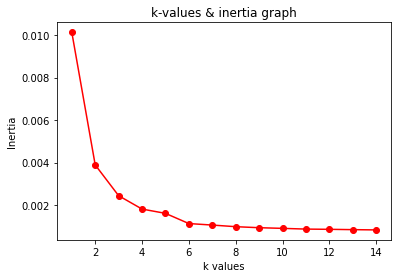

In [64]:
k_vals = range(1,15)
y = []
for k in k_vals:
  k_mean = KMeans(n_clusters=k, n_init=50, max_iter=100, init='random')
  k_mean.fit(X)
  y.append(k_mean.inertia_)

plt.plot(k_vals, y, 'ro-')
plt.xlabel('k values')
plt.ylabel('Inertia')
plt.title('k-values & inertia graph')
plt.show()

Looking at the number of clusters we can see that @k=3 the curve is bent and upper values can make a slight change  
I also tried @k=4 clusters but two clusters were highly similiar

In [74]:
k_mean = KMeans(n_clusters=3, n_init=40, init='k-means++') 
k_mean.fit(X)
labels = k_mean.labels_
final_df['assigned_cluster'] = labels
final_df.head(10)

,product_id,likes,dislikes,recommended,not_recommended,no_idea,product_title,assigned_cluster
0,300,5,1,2,1,0,پرینتر لیزری اچ پی مدل LaserJet P2035,1
1,310,2,0,1,0,0,اچ پی لیزر جت پی 2055 دی,2
2,352,0,0,0,0,1,گوشی موبایل نوکیا 5800 نویگیشن ادیشن,0
3,363,0,0,1,0,0,گوشی موبایل نوکیا 6303 کلاسیک,0
4,423,0,0,1,0,0,لپ تاپ ایسر اسپایر 5738 زد جی,0
5,481,1,0,0,0,0,سونی پلی استیشن 2,0
6,482,1,1,1,0,0,سونی پلی استیشن پورتابل (پی اس پی) - 3000,2
7,485,0,0,0,0,0,گوشی موبایل نوکیا 6500 اسلاید,0
8,496,0,0,0,0,1,نینتندو وی,0
9,515,9,0,1,0,0,گوشی موبایل نوکیا ان 82,1


we have 3 clusters  
to have an idea about what each data clusters contain

In [79]:
cluster_groups = final_df.groupby(by="assigned_cluster")
cluster_groups.head(20)

,product_id,likes,dislikes,recommended,not_recommended,no_idea,product_title,assigned_cluster
0,300,5,1,2,1,0,پرینتر لیزری اچ پی مدل LaserJet P2035,1
1,310,2,0,1,0,0,اچ پی لیزر جت پی 2055 دی,2
2,352,0,0,0,0,1,گوشی موبایل نوکیا 5800 نویگیشن ادیشن,0
3,363,0,0,1,0,0,گوشی موبایل نوکیا 6303 کلاسیک,0
4,423,0,0,1,0,0,لپ تاپ ایسر اسپایر 5738 زد جی,0
5,481,1,0,0,0,0,سونی پلی استیشن 2,0
6,482,1,1,1,0,0,سونی پلی استیشن پورتابل (پی اس پی) - 3000,2
7,485,0,0,0,0,0,گوشی موبایل نوکیا 6500 اسلاید,0
8,496,0,0,0,0,1,نینتندو وی,0
9,515,9,0,1,0,0,گوشی موبایل نوکیا ان 82,1


Cluster 0 contains items which are unpopular   
Cluster 1 contains items which are most popular with largest recommendation, likes, dislikes   
Cluster 2 contains items which are liked and moderately popular   


<hr>

# Part 2: Clustering based on sales in each city

In [184]:
orders = pd.read_csv("/content/drive/MyDrive/Clustering_according_to_item_popularity/orders.csv")
orders.head()

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item
0,2714054,469662,21386,2015-10-15 08:50:56.000,597982.0,محمود آباد,1.0
1,11104039,3063877,248497,2018-02-11 00:29:26.000,980000.0,خرمدره,1.0
2,4228130,3184893,50144,2016-06-14 00:30:08.000,229358.0,قرچک,1.0
3,22225624,6888562,70208,2018-09-03 14:37:19.000,16514.0,قم,1.0
4,4068771,2533490,67627,2016-05-21 11:51:02.000,133028.0,تهران,1.0


We will need the city name and sum of quantities from that item so

In [185]:
orders = orders.filter(['city_name_fa', 'Quantity_item'])
orders.head()

,city_name_fa,Quantity_item
0,محمود آباد,1.0
1,خرمدره,1.0
2,قرچک,1.0
3,قم,1.0
4,تهران,1.0


In [186]:
orders = orders.groupby('city_name_fa', as_index=False).sum()
orders.head()

,city_name_fa,Quantity_item
0,آب بر,15.0
1,آبادان,493.0
2,آباده,84.0
3,آباده طشک,3.0
4,آبدان,2.0


In [187]:
orders.describe()

,Quantity_item
count,906.000000
mean,278.416115
std,4569.275593
min,1.000000
25%,3.000000
50%,11.000000
75%,54.000000
max,136538.000000


Let's check the dataframe for possible outliers

In [188]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 905
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   city_name_fa   906 non-null    object 
 1   Quantity_item  906 non-null    float64
dtypes: float64(1), object(1)
memory usage: 21.2+ KB


In [189]:
lof = LocalOutlierFactor(contamination=0.01, n_neighbors=10)
temp = orders['Quantity_item'].values.reshape(-1,1)
yhat = lof.fit_predict(temp)
mask = yhat != -1
# # for i in range(0, len(mask)):
# #   if mask[i] = True:
# orders.info()
for index, row in orders.iterrows():
  if mask[index] != True:
    orders_outlier = orders.drop(index=index)
orders_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 905
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   city_name_fa   905 non-null    object 
 1   Quantity_item  905 non-null    float64
dtypes: float64(1), object(1)
memory usage: 21.2+ KB


1 cities as outliers removed

In [191]:
X_train = orders_outlier['Quantity_item'].tolist()
X_train

[15.0,
 493.0,
 84.0,
 3.0,
 2.0,
 52.0,
 8.0,
 4.0,
 3.0,
 18.0,
 2.0,
 15.0,
 1.0,
 110.0,
 1.0,
 31.0,
 14.0,
 71.0,
 60.0,
 1.0,
 135.0,
 11.0,
 209.0,
 2.0,
 15.0,
 42.0,
 5.0,
 47.0,
 2.0,
 3.0,
 1273.0,
 2.0,
 1.0,
 57.0,
 9.0,
 176.0,
 1.0,
 2.0,
 7.0,
 5.0,
 10.0,
 2.0,
 1.0,
 1.0,
 1229.0,
 3.0,
 979.0,
 57.0,
 5.0,
 271.0,
 7.0,
 5.0,
 2.0,
 5.0,
 1393.0,
 2.0,
 4.0,
 59.0,
 1.0,
 6.0,
 51.0,
 60.0,
 20.0,
 1.0,
 86.0,
 1.0,
 127.0,
 566.0,
 1.0,
 2.0,
 12.0,
 1.0,
 22.0,
 20.0,
 24.0,
 10.0,
 7552.0,
 2.0,
 10.0,
 57.0,
 61.0,
 1.0,
 125.0,
 115.0,
 1.0,
 46.0,
 169.0,
 77.0,
 2.0,
 2.0,
 22.0,
 2.0,
 2.0,
 326.0,
 126.0,
 112.0,
 24.0,
 5559.0,
 25.0,
 7.0,
 118.0,
 124.0,
 22.0,
 525.0,
 6.0,
 17.0,
 35.0,
 9.0,
 2.0,
 4.0,
 1419.0,
 580.0,
 3.0,
 17.0,
 2.0,
 18.0,
 4.0,
 3.0,
 13.0,
 23.0,
 20.0,
 35.0,
 82.0,
 21.0,
 86.0,
 3.0,
 1.0,
 9.0,
 573.0,
 1.0,
 17.0,
 132.0,
 6.0,
 4.0,
 41.0,
 37.0,
 1.0,
 2.0,
 3.0,
 328.0,
 126.0,
 29.0,
 78.0,
 18.0,
 28.0,
 5.0,
 1.0,
 

In [196]:
X = np.array(X_train)
X = X.reshape(-1, 1)

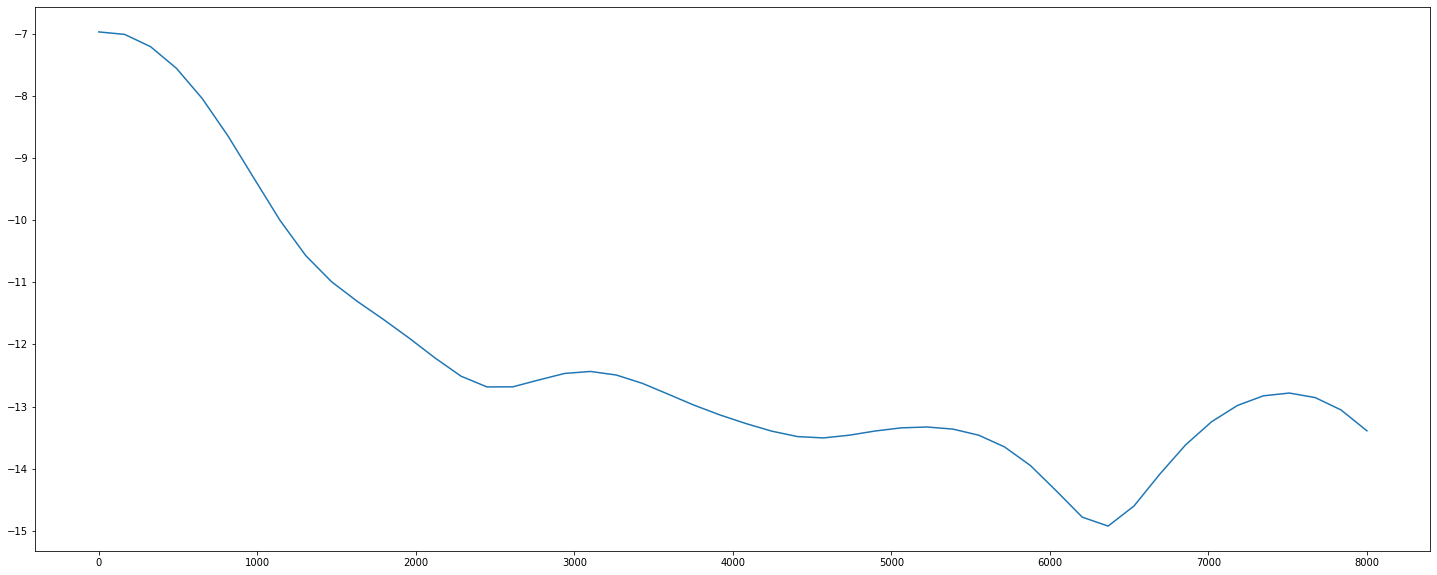

In [198]:
plt.figure(figsize=(25, 10))
kde = KernelDensity(kernel='gaussian', bandwidth=400).fit(X)
n_samples = np.linspace(0,9000)
scores = kde.score_samples(s.reshape(-1,1))
plt.plot(s, e)

there are 3 minimas

In [204]:
minimas, maximas = argrelextrema(scores, np.less)[0], argrelextrema(scores, np.greater)[0]
points = list(np.int_(n_samples[minimas]))
ranges = {range(0, points[0] + 1): 3, range(points[0] + 1, points[1] + 1): 2, range(points[1] + 1, points[2] + 1): 1, range(points[2] + 1, 400000): 0}
orders['class'] = orders['Quantity_item'].apply(lambda x: next((v for k, v in ranges.items() if x in k), 0))
orders.head()

,city_name_fa,Quantity_item,class
0,آب بر,15.0,3
1,آبادان,493.0,3
2,آباده,84.0,3
3,آباده طشک,3.0,3
4,آبدان,2.0,3


In [205]:
orders_grouped = orders.groupby(by=['class'])
orders_grouped.first()

,city_name_fa,Quantity_item
class,,
0,اصفهان,7552.0
1,اهواز,5559.0
2,تبریز,3512.0
3,آب بر,15.0


We have obtainded 4 classes of cities as:  
0 the cities with highest sales to 3 the cities with lowest sales

In [206]:
for group, items in orders_grouped:
  print('Class: ', group, '\n 10 cities: ', items['city_name_fa'].tolist()[:10])

Class:  0 
 10 cities:  ['اصفهان', 'تهران', 'مشهد']
Class:  1 
 10 cities:  ['اهواز', 'کرج']
Class:  2 
 10 cities:  ['تبریز', 'رشت', 'شیراز', 'قم', 'کرمانشاه', 'یزد']
Class:  3 
 10 cities:  ['آب بر', 'آبادان', 'آباده', 'آباده طشک', 'آبدان', 'آبدانان', 'آبسرد', 'آبش احمد', 'آبعلی', 'آبپخش']
